In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# **Voorbereiden datasets**

In [3]:
# Read and prepare Gini coefficient dataset
gini_coefficient_df = pd.read_csv('/content/drive/MyDrive/OefendataWinc/economic-inequality-gini-index.csv', encoding='unicode_escape')

# Rename columns
gini_coefficient_df.rename(columns={'Entity' : 'Country', 'Code' : 'Land_code', 
                                    'Gini coefficient' : 'Gini_coefficient'}, 
                           inplace=True)

# Remove rows with a NaN value for Land_code to use data from only countries
gini_coefficient_df.dropna(subset=['Land_code'], inplace=True)

display(gini_coefficient_df)

,Country,Land_code,Year,Gini_coefficient
0,Albania,ALB,1996,0.270103
1,Albania,ALB,2002,0.317390
2,Albania,ALB,2005,0.305957
3,Albania,ALB,2008,0.299847
4,Albania,ALB,2012,0.289605
...,...,...,...,...
2120,Zambia,ZMB,2010,0.556215
2121,Zambia,ZMB,2015,0.571361
2122,Zimbabwe,ZWE,2011,0.431536
2123,Zimbabwe,ZWE,2017,0.443371


In [4]:
# Read and prepare GDP dataset
gdp_df = pd.read_csv('/content/drive/MyDrive/OefendataWinc/gdp-per-capita-maddison-2020.csv', encoding='unicode_escape')

# Drop last column
gdp_df.drop(columns='417485-annotations', inplace=True)

# Rename columns
gdp_df.rename(columns={'Entity' : 'Country', 'Code' : 'Land_code', 
                       'GDP per capita' : 'GDP'}, inplace=True)

# Remove rows with a NaN value for Land_code to use data from only countries
gini_coefficient_df.dropna(subset=['Land_code'], inplace=True)

display(gdp_df)

,Country,Land_code,Year,GDP
0,Afghanistan,AFG,1950,1156.000000
1,Afghanistan,AFG,1951,1170.000000
2,Afghanistan,AFG,1952,1189.000000
3,Afghanistan,AFG,1953,1240.000000
4,Afghanistan,AFG,1954,1245.000000
...,...,...,...,...
19871,Zimbabwe,ZWE,2014,1594.000000
19872,Zimbabwe,ZWE,2015,1560.000000
19873,Zimbabwe,ZWE,2016,1534.000000
19874,Zimbabwe,ZWE,2017,1582.366211


In [5]:
# Merge dataframes
gdp_gini_coef_df = pd.merge(gini_coefficient_df, gdp_df, on=['Country', 'Land_code', 'Year'])
display(gdp_gini_coef_df)

,Country,Land_code,Year,Gini_coefficient,GDP
0,Albania,ALB,1996,0.270103,3965.685303
1,Albania,ALB,2002,0.317390,5608.962402
2,Albania,ALB,2005,0.305957,6858.466797
3,Albania,ALB,2008,0.299847,8522.129883
4,Albania,ALB,2012,0.289605,9592.000000
...,...,...,...,...,...
1805,Zambia,ZMB,2006,0.546175,2133.593994
1806,Zambia,ZMB,2010,0.556215,3032.067871
1807,Zambia,ZMB,2015,0.571361,3478.000000
1808,Zimbabwe,ZWE,2011,0.431536,1515.000000


# **Berekening Pearson correlatie**

In [6]:
# Calulate Pearson correlation and p-value per country
filtered_df = gdp_gini_coef_df.groupby(['Country']).filter(lambda x: x['Year'].nunique() >= 2)
correlation_df = filtered_df.groupby(['Country']).apply(lambda d: pd.Series(pearsonr(d['Gini_coefficient'], d['GDP']), index=["Pearson_correlation", "P-value"]))

In [7]:
# Determine group size and add to DataFrame
correlation_df['Group_size'] = gdp_gini_coef_df.groupby(['Country']).size()
display(correlation_df)

,Pearson_correlation,P-value,Group_size
Country,,,
Albania,0.567214,0.087260,10
Algeria,-0.934937,0.230911,3
Angola,-0.409606,0.731332,3
Armenia,-0.583625,0.006903,20
Australia,0.819584,0.001102,12
...,...,...,...
Venezuela,0.090274,0.769300,13
Vietnam,-0.141560,0.678009,11
Yemen,-0.587702,0.600066,3


In [8]:
# FUNCTIONS
# Determine correlation strength
def determine_corr_strength(corr_values_list):
  correlation_strength = []

  for corr_value in corr_values_list:
    if isinstance(corr_value, float):
      corr_value *= -1
      if corr_value < 0.10:
        correlation_strength.append('Negligible')
      elif corr_value >= 0.10 and corr_value < 0.20:
        correlation_strength.append('Weak')
      elif corr_value >= 0.20 and corr_value < 0.40:
        correlation_strength.append('Moderate')
      elif corr_value >= 0.40 and corr_value < 0.60:
        correlation_strength.append('Relatively strong')
      elif corr_value >= 0.60 and corr_value < 0.80:
        correlation_strength.append('Strong')
      elif corr_value >= 0.80 and corr_value <= 1.00:
        correlation_strength.append('Very strong')
    else:
      correlation_strength.append('Unable to determine correlation strength')

  return correlation_strength


# Determine relationship
def determine_corr_relationship(corr_values_list):
  relationship_list = []

  for corr_value in corr_values_list:  
    if isinstance(corr_value, float):
      if corr_value == 0:
        relationship_list.append('No linear relationship')
      elif corr_value < 0 and corr_value >= -1:
        relationship_list.append('Negative linear relationship')
      elif corr_value > 0 and corr_value <= 1:
        relationship_list.append('Positive linear relationship')
    else:
      relationship_list.append('Unable to determine relationship')

  return relationship_list


# Determine significance
def determine_corr_significance(p_values_list):
  significance_list = []

  for p_value in p_values_list:  
    if isinstance(p_value, float):
      if p_value < 0.05:
        significance_list.append('Significant')
      elif p_value >= 0.05:
        significance_list.append('Not significant')
    else:
      significance_list.append('Unable to determine significance')

  return significance_list

In [9]:
# Determine correlation strength and add to dataframe
correlation_strength = determine_corr_strength(correlation_df['Pearson_correlation'].tolist())
correlation_df['Correlation_strength'] = correlation_strength

# Determine correlation relationship and add to dataframe
relationship = determine_corr_relationship(correlation_df['Pearson_correlation'].tolist())
correlation_df['Relationship'] = relationship

# Determine significance correlation and add to dataframe
significance = determine_corr_significance(correlation_df['P-value'].tolist())
correlation_df['Significance'] = significance

display(correlation_df)

,Pearson_correlation,P-value,Group_size,Correlation_strength,Relationship,Significance
Country,,,,,,
Albania,0.567214,0.087260,10,Negligible,Positive linear relationship,Not significant
Algeria,-0.934937,0.230911,3,Very strong,Negative linear relationship,Not significant
Angola,-0.409606,0.731332,3,Relatively strong,Negative linear relationship,Not significant
Armenia,-0.583625,0.006903,20,Relatively strong,Negative linear relationship,Significant
Australia,0.819584,0.001102,12,Negligible,Positive linear relationship,Significant
...,...,...,...,...,...,...
Venezuela,0.090274,0.769300,13,Negligible,Positive linear relationship,Not significant
Vietnam,-0.141560,0.678009,11,Weak,Negative linear relationship,Not significant
Yemen,-0.587702,0.600066,3,Relatively strong,Negative linear relationship,Not significant


# **Analyse**

**Verklaring van termen:**
- Gross Domestic Product (GDP) oftewel het Bruto Binnenlands Product (BBP): de totale toegevoegde waarde van alle in een land geproduceerde goederen en diensten gedurende een bepaalde periode (meestal een jaar).
- Gini coëfficient: een statistische maatstaf van de ongelijkheid in inkomen of vermogen.
</br></br>

**Datavoorbereiding:**
- Na het inlezen van de datasets zijn bij allebei de rijen verwijderd waar geen landcode beschikbaar is. Op deze manier is enkel de data behouden van individuele landen en geen combinaties van landen.
- De DataFrames met het GDP en de Gini coëfficient werden gemerged op basis van het land, de landcode en het jaar. 
- Voor de berekening van de Pearson correlatie zijn enkel landen gebruikt met twee of meer metingen.
</br></br>

**Klassificatie sterkte correlatie:**
- Pearson correlatie < 0.10 / Pearson correlatie < -0.10: Negligible (verwaarloosbaar).
- Pearson correlatie >= 0.10 en < 0.20 / Pearson correlatie <= -0.10 en > -0.20: Weak (zwak).
- Pearson correlatie >= 0.20 en < 0.40 / Pearson correlatie <= -0.20 en > -0.40: Moderate (matig).
- Pearson correlatie >= 0.40 en < 0.60 / Pearson correlatie <= -0.40 en > -0.60: Relatively strong (relatief sterk).
- Pearson correlatie >= 0.60 en < 0.80 / Pearson correlatie <= -0.60 en > -0.80: Strong (sterk).
- Pearson correlatie >= 0.80 en <= 1.00 / Pearson correlatie <= -0.80 en >= -1.00: Very strong (zeer sterk).
</br></br>

**Klassificatie soort verband:**
- Pearson correlatie is 0: No linear relationship (geen lineair verband)
- Pearson correlatie is < 0 en >= -1: Negative linear relationship (negatief lineair verband)
- Pearson correlatie is > 0 en <= 1: Positive linear relationship (positief lineair verband)
</br></br>

**Klassificatie significantie:**
- P-waarde < 0.05: Significant
- P-waarde > 0.05: Non significant (niet significant)

# **Vraag: Is er sprake van een verband tussen het GDP en de inkomensongelijkheid van een land?**

Het doel van de analyse is om te bepalen of er een verband is tussen het GPD en de Gini coëfficient en wat voor soort verband dit dan is. De eerste stap is om de data van deze variabelen te bekijken door middel van een histogram. Hierdoor wordt duidelijk wat de verdeling is van de data, wat het minimum en maximum is, en of er sprake is van uitschieters.
</br></br>
Uit de histogrammen is te concluderen dat er voor beide variabelen geen sprake is van een symmetrische verdeling. Beide histogrammen zijn right-skewed. Dit betekent dat de meeste waarden zich aan de linkerkant van de histogram bevinden. Dit is zeer duidelijk te zien in de histogram voor het GDP.
</br>

In het geval van het GDP is ook te zien dat er sprake is van enkele uitschieters met een hoge waarde. De meeste datapunten vallen binnen de categorieën t/m 60000. Daarboven bevinden zich enkele uitzonderingen.
</br>
In de data van de Gini coëfficient is geen sprake van uitschieters.

Text(0.5, 1.0, 'Distibution of GDP')

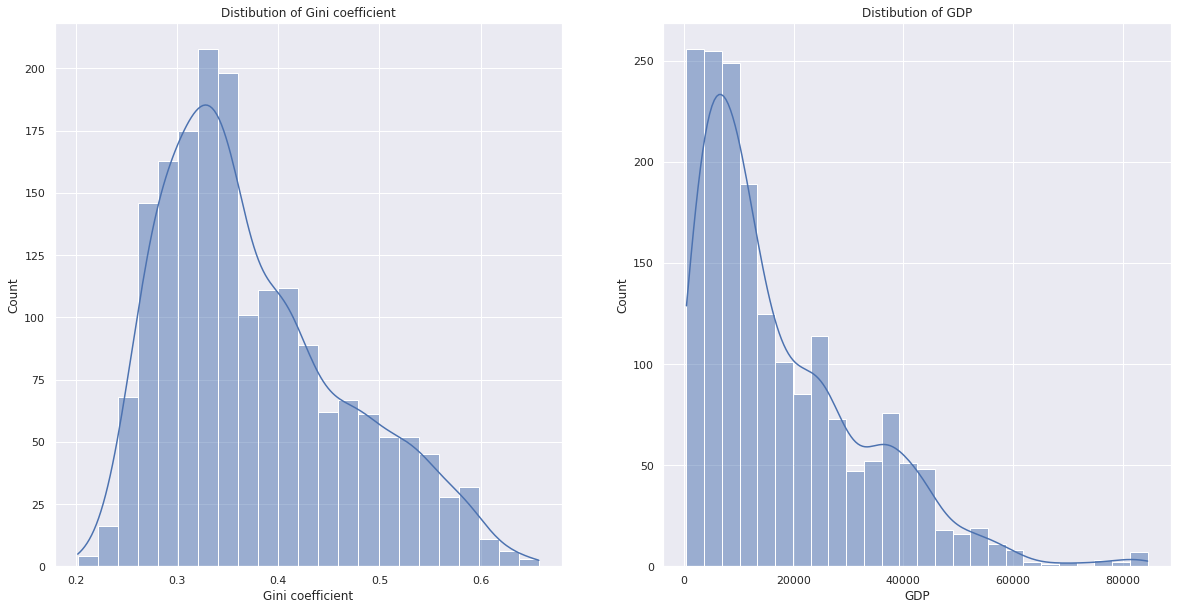

In [11]:
# Distribution of Gini coefficient and GDP
sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize = (20,10))
sns.histplot(gdp_gini_coef_df, x="Gini_coefficient", kde=True, ax=axs[0])
axs[0].set_title("Distibution of Gini coefficient")
axs[0].set_xlabel("Gini coefficient")

sns.histplot(gdp_gini_coef_df, x="GDP", kde=True, ax=axs[1])
axs[1].set_title("Distibution of GDP")

Een volgende stap is om te kijken of er sprake is van een verband tussen de twee veriabelen. Dit wordt als eerste gedaan door het plotten van de twee variabelen in een scatterplot waaraan een regressielijn wordt toegevoegd. De regressielijn vertelt of er sprake is van een lineair verband tussen het GDP en de Gini coëfficient.
</br>
In de onderstaande plot is het resultaat te zien van deze analyse. Hieruit is te concluderen dat er op wereldniveau sprake is van een negatieve regressielijn. Dit betekent dat de Gini coëfficient toeneemt wanneer het GDP omlaag gaat en andersom. Dit wil zeggen dat de inkomensongelijkheid toeneemt wanneer het GDP afneemt.

Text(0.5, 25.959999999999994, 'Gini coefficient')

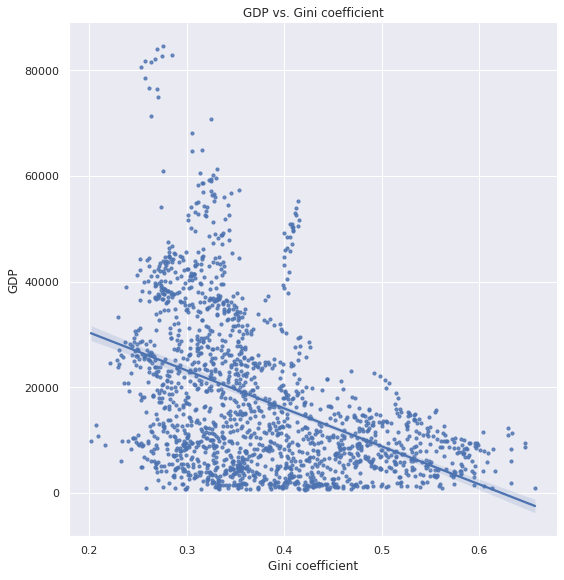

In [12]:
sns.set(style="darkgrid")
sns.lmplot(x='Gini_coefficient', y='GDP', data=gdp_gini_coef_df, scatter_kws={'s':10}, height=8)
ax = plt.gca()
ax.set_title("GDP vs. Gini coefficient")
ax.set_xlabel("Gini coefficient")

Vervolgens wordt gekeken naar de correlatie tussen GPD en de Gini coëfficient. Door het berekenen van de Pearson correlatie is het mogelijk om te bepalen hoe sterk het verband tussen de twee variabelen is. Door naast de Pearson correlatie ook de p-waarde te berekenen is het mogelijk om te bepalen of de correlatie significant is.
</br></br>
De correlatie kan berekend worden op landelijk niveau maar ook op wereldniveau. Als eerste is gekozen om de correlatie te verkennen op landelijk niveau. Enkel de landen waarbij sprake is van een siginificante correlatie met een p-waarde kleiner dan 0.05 en een relatief sterke, sterke of zeer sterke correlatie zijn geselecteerd. Dit zijn 38 landen van de in totaal 144 landen. Wanneer het GDP en de Gini coëfficient van deze 38 landen worden geplot met een regressielijn is te zien dat er sprake is van een negatief verband. Dit betekent dat de Gini coëfficient toeneemt wanneer het GDP afneemt en andersom. 

Niet ieder land heeft hetzelfde aantal metingen. Hierin zijn grote verschillen waar te nemen. In de geselecteerde dataset verschilt dit tussen 5 en 34 metingen per land. De sample size was dus redelijk laag. Dit heeft invloed op de betrouwbaarheid van de correlatie. Wat beschouwt wordt als ideale sample size verschilt. Wanneer gekozen wordt voor een sample size van minimaal 25 blijven enkel 3 landen over. De betrouwbaarheid van de correlatie is voor de meeste landen dus niet geheel betrouwbaar vanwege het lage aantal metingen. 
</br></br>
Wanneer gekeken wordt naar de individuele landen is voor 38 landen sprake van een significante negatieve correlatie die relatief sterk tot zeer sterk is tussen het GDP en de Gini coëfficient. Voor 20 landen is er sprake van een significante correlatie, maar waarbij de sterkte van de correlatie minder is dan relatief sterk. Voor de 86 overige landen is dus geen sprake van een significante correlatie. Het feit dat sprake is van zo weinig significante correlaties zou kunnen komen omdat voor sommige landen maar weinig data beschikbaar was. Het kan echter ook zo zijn dat voor sommige landen er geen correlatie is tussen de twee variabelen.

Text(0.5, 25.959999999999994, 'Gini coefficient')

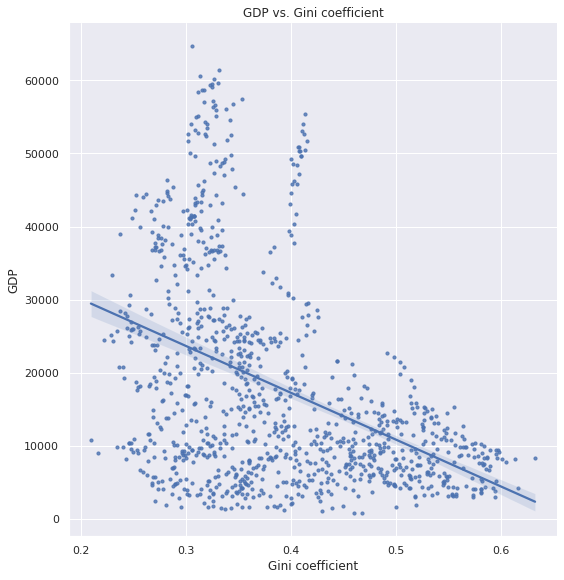

In [13]:
# Significant correlations with a relative strong, strong or very strong correlation
significant_corr_df = correlation_df.loc[(correlation_df['Significance'] == 'Significant') & (correlation_df['Correlation_strength'] != 'Negligible')]
# display(significant_corr_df)
# display(significant_corr_df.shape)

# Significant correlations
significant_corr_df = correlation_df.loc[(correlation_df['Significance'] == 'Significant')]
# display(significant_corr_df)
countries = significant_corr_df.index.tolist()
selection_df = gdp_gini_coef_df[gdp_gini_coef_df['Country'].isin(countries)]

sns.set(style="darkgrid")
sns.lmplot(x='Gini_coefficient', y='GDP', data=selection_df, scatter_kws={'s':10}, height=8)
ax = plt.gca()
ax.set_title("GDP vs. Gini coefficient")
ax.set_xlabel("Gini coefficient")

Als laatste is gekeken over er sprake is van een verband tussen GDP en de Gini coëfficient op wereldniveau. Hierbij worden alle landen met beschikbare metingen gebruikt. Dit zijn 1810 metingen. Uit deze berekening komt een Pearson correlatie van -0.43. Dit betekent dat er een relatief sterk verband is tussen het GDP en de Gini coëfficient. Dat het getal negatief is, betekent dat er wederom een negatief verband wordt gevonden tussen deze twee variabelen. Wanneer de Gini coëfficient omhoog gaat, dan gaat het GDP omlaag. 
</br>
De p-waarde die hoort bij deze correlatie is 2.71e-83. Dit is lager dan 0.05 wat betekent dat de berekende Pearson correlatie zeer significant is. 

In [14]:
# Calculate global correlation and p-value
global_pearson_corr = pearsonr(gdp_gini_coef_df['Gini_coefficient'], gdp_gini_coef_df['GDP'])
print(global_pearson_corr)

(-0.4322580717577245, 2.705271601736767e-83)


De vraag om te beantwoorden na deze analyse was: 
</br>
**Is er sprake van een verband tussen het GDP en de inkomensongelijkheid van een land?**
</br></br>
Op wereldiveau kan gezegd worden dat er sprake is van een significant negatief verband tussen het GDP en de Gini coëfficient. Dit betekent dat de inkomensongelijkheid groter wordt naarmate het GDP afneemt en andersom.
</br></br>
Op landelijk niveau is echter minder duidelijk een verband te bepalen. Voor 38 van de 144 landen was sprake van een significant relatief sterk tot zeer sterk negatief verband tussen het GDP en de Gini coëfficient. Dit is hetzelfde verband als op wereldniveau wordt gevonden. Voor 20 landen was er wel sprake van een significante correlatie maar was de sterkte van het verband minder dan relatief sterk. Voor de overige 86 landen was geen sprake van een significante correlatie tussen de twee variabelen. Dit zou kunnen komen omdat voor sommige landen te weinig metingen zijn opgenomen om significante correlaties te berekenen of er is simpelweg geen sprake van een correlatie tussen GDP en de Gini coëffient voor deze landen. 



